In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import os

In [2]:
datasets = ["ADP", "PBMC", "MSB", "MBC"]

maps = {
    "dendritic cell": "Dendritic Cells",
    "endothelial cell": "Endothelial Cells",
    "immature NK T cell": "Immature NK T Cells",
    "monocyte": "Monocytes",
    "preadipocyte": "Preadipocytes",
    "T cell": "T Cells",
    "Endothelial cell": "Endothelial Cells",
    "T cell": "T Cells",
    "Macrophage": "Macrophages",
    "macrophage": "Macrophages",
    "Hepatocyte": "Hepatocytes",
    "Epithelial cell": "Epithelial Cells",
}

method_mapping = {
    "raw_sn": "snRNA",  # untransformed SN
    "pca_sn": "PCA",  # PCA‐aligned SN
    "scvi_sn": "scVIcond",  # conditional scVI
    "scvilsshift_sn": "scVILS",  # local‐shift scVI
    "raw_sc": "scRNA (PosCtrl)",  # SC positive control
}

desired_order = ["snRNA", "PCA", "scVILS", "scVIcond"]

display_palette = {
    "snRNA": "rosybrown",
    "PCA": "#2ca02c",
    "scVILS": "darkorange",
    "scVIcond": "#9467bd",
    "scRNA (PosCtrl)": "#1f77b4",
}

In [3]:
base_dir = ".."
# Ground-truth proportions file from deconvolution data folder
results = {}
for ds in datasets:
    results_path = os.path.join(base_dir, "results", ds)
    results_file = os.path.join(results_path, f"results_{ds}.csv")
    if not os.path.exists(results_file):
        print(f"Missing results for {ds}: {results_file}. Skipping.")
        continue
    results[ds] = pd.read_csv(results_file)
results[ds]

,SampleID,CellType,PredProp,TrueProp,Transform,HoldoutCell
0,1,Epithelial cell,0.466945,0.762444,degIntSN,Endothelial cell
1,2,Epithelial cell,0.244851,0.139331,degIntSN,Endothelial cell
2,3,Epithelial cell,0.211270,0.058926,degIntSN,Endothelial cell
3,4,Epithelial cell,0.461410,0.743171,degIntSN,Endothelial cell
4,5,Epithelial cell,0.468119,0.757450,degIntSN,Endothelial cell
...,...,...,...,...,...,...
284995,996,T cell,0.539704,0.011430,sn_raw,NaN
284996,997,T cell,0.583806,0.048380,sn_raw,NaN
284997,998,T cell,0.757379,0.080400,sn_raw,NaN
284998,999,T cell,0.559643,0.138510,sn_raw,NaN


In [4]:
# --- Normalisation helper ----------------------------------------------------
def libsize_log1p(df):
    """
    CPM normalisation (counts-per-million) + log1p.
    df: genes × cells DataFrame of raw counts
    returns: genes × cells DataFrame on the same index/columns
    """
    # 1) library size scaling  (add tiny epsilon to avoid divide-by-zero)
    cpm = df.div(df.sum(axis=0) + 1e-8, axis=1) * 1e6
    # 2) log1p transform
    return np.log1p(cpm)

In [5]:
def subsample_and_pseudobulk(df, n_cells=50, random_state=None):
    """
    1. Randomly pick n_cells columns.
    2. Sum counts across those cells (genes × 1).
    3. Return as a DataFrame (genes × 1).
    """
    if df.shape[1] > n_cells:
        rng = np.random.default_rng(random_state)
        cols = rng.choice(df.columns, n_cells, replace=False)
        df = df[cols]

    pseudobulk = df.sum(axis=1).to_frame("bulk")  # keep gene index
    return pseudobulk


def compute_cosine_similarity(matrix1, matrix2, n_sub=50, random_state=42):
    # 1) Intersect genes
    common = matrix1.index.intersection(matrix2.index)
    if common.empty:
        raise ValueError("No overlapping genes between the two matrices.")
    m1, m2 = matrix1.loc[common], matrix2.loc[common]

    # 2) Subsample ➜ pseudobulk (sum counts)
    m1_bulk = subsample_and_pseudobulk(m1, n_sub, random_state)
    m2_bulk = subsample_and_pseudobulk(m2, n_sub, random_state)

    # 3) CPM + log1p  (single column each)
    m1_norm = libsize_log1p(m1_bulk)
    m2_norm = libsize_log1p(m2_bulk)

    # 4) Get the two vectors and cosine-sim
    v1 = m1_norm.iloc[:, 0].values
    v2 = m2_norm.iloc[:, 0].values

    return cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0, 0]
    #r, p = pearsonr(v1.reshape(1, -1), v2.reshape(1, -1))
    # return p

In [6]:
def visualize_reference_similarity(desired_order, df_metrics, display_palette, ds):
    # --- Visualization ---
    sns.set(style="whitegrid", context="talk")

    plt.figure(figsize=(29, 20))
    ax = sns.barplot(
        x="CellType",
        y="Cosine",
        hue="Display",
        hue_order=desired_order,
        data=df_metrics[df_metrics.Method != "raw_sc"],
        palette=display_palette,
    )

    plt.title(
        f"{ds}\nsnRNA-seq vs. scRNA-seq Av. Expression",
        fontsize=80,
        fontweight="bold",
        pad=18,
    )
    plt.ylabel("Cosine Similarity", fontsize=60, fontweight="bold")
    plt.xlabel(
        "Cell Type", fontsize=60, fontweight="bold"
    )  # Changed label from "CellType" to "Cell Type"
    plt.xticks(rotation=45, fontsize=60)
    plt.yticks(fontsize=50)
    plt.tight_layout()

    # Get the legend and update its title and text properties.
    leg = plt.legend(bbox_to_anchor=(1, 0.5), title="Method")
    leg.set_title("Transform", prop={"size": 50, "weight": "bold"})
    for text in leg.get_texts():
        text.set_fontsize(40)
    plt.show()

In [7]:
def reference_similarity_analysis(
    ds, base_dir, results, desired_order, display_palette, maps
):

    # data_deconv_path = os.path.join(base_dir, "data", "deconvolution", ds)
    data_deconv_path = os.path.join(base_dir, ds)
    print(data_deconv_path)

    raw_sn = {}
    raw_sc = {}
    pca_sn = {}
    scvi_sn = {}
    scvilsshift_sn = {}

    # all_sn = pd.read_csv(f"{data_deconv_path}/sn_raw_signal.csv", index_col=0)
    all_sc = pd.read_csv(f"{data_deconv_path}/sc_raw_signal.csv", index_col=0)

    # all_sn_cellst = pd.read_csv(f"{data_deconv_path}/sn_raw_cell_state.csv")
    all_sc_cellst = pd.read_csv(f"{data_deconv_path}/sc_raw_cell_state.csv")

    # all_sn.columns = range(1, all_sn.shape[1] + 1)
    all_sc.columns = range(1, all_sc.shape[1] + 1)

    for cell in all_sc_cellst.cell_type.unique():

        print(cell)
        cell_path = cell.replace(" ", "_")

        pca_sn[cell] = pd.read_csv(
            f"{data_deconv_path}/ref_{cell_path}_pcaSN_signal.csv", index_col=0
        )
        scvi_sn[cell] = pd.read_csv(
            f"{data_deconv_path}/ref_{cell_path}_scviSN_signal.csv", index_col=0
        )
        scvilsshift_sn[cell] = pd.read_csv(
            f"{data_deconv_path}/ref_{cell_path}_scvi_LSshift_SN_signal.csv",
            index_col=0,
        )
        raw_sn[cell] = pd.read_csv(
            f"{data_deconv_path}/ref_{cell_path}_rawSN_signal.csv", index_col=0
        )
        cell_idx = pd.read_csv(
            f"{data_deconv_path}/ref_{cell_path}_pcaSN_cell_state.csv"
        )

        cell_idx = cell_idx[cell_idx["cell_type"] == cell]
        cell_idx = cell_idx["cell_id"].values

        cell_idx_raw_sc = all_sc_cellst[all_sc_cellst["cell_type"] == cell]
        cell_idx_raw_sc = cell_idx_raw_sc["cell_id"].values

        raw_sc[cell] = all_sc[cell_idx_raw_sc]

        ## Our columns are in R, we add a 1.
        pca_sn[cell].columns = range(1, pca_sn[cell].shape[1] + 1)
        scvi_sn[cell].columns = range(1, scvi_sn[cell].shape[1] + 1)
        scvilsshift_sn[cell].columns = range(1, scvilsshift_sn[cell].shape[1] + 1)
        raw_sn[cell].columns = range(1, raw_sn[cell].shape[1] + 1)

        pca_sn[cell] = pca_sn[cell][cell_idx]
        scvi_sn[cell] = scvi_sn[cell][cell_idx]
        scvilsshift_sn[cell] = scvilsshift_sn[cell][cell_idx]
        raw_sn[cell] = raw_sn[cell][cell_idx]

        raw_sc[cell] = raw_sc[cell][cell_idx_raw_sc]

    # --- Define the methods to compare ---
    # We assume that pca_sn, scvi_sn, raw_sn, raw_sc, and scvilsshift_sn are already defined.
    methods = {
        "pca_sn": pca_sn,
        "scvi_sn": scvi_sn,
        "raw_sn": raw_sn,  # Negative control (untransformed SN)
        "raw_sc": raw_sc,  # Positive control (SC reference)
        "scvilsshift_sn": scvilsshift_sn,
    }

    # --- Aggregate results[ds] across cell types ---
    results_list = []

    for cell in results[ds].CellType.unique():
        # Get the SC reference matrix for this cell type.
        sc_matrix = raw_sc[cell]

        # Loop over each method.
        for method_name, method_dict in methods.items():
            method_matrix = method_dict[cell]
            cosine_val = compute_cosine_similarity(method_matrix, sc_matrix)

            results_list.append(
                {"CellType": cell, "Method": method_name, "Cosine": cosine_val}
            )

    # Create a DataFrame from the results[ds].
    df_metrics = pd.DataFrame(results_list)
    print("Aggregated Similarity Metrics:")
    print(df_metrics)

    # --- Map internal method names to professional display names ---
    # We'll use the same mapping as before.
    df_metrics["Display"] = df_metrics["Method"].map(method_mapping)
    df_metrics["CellType"] = df_metrics["CellType"].replace(maps)

    visualize_reference_similarity(desired_order, df_metrics, display_palette, ds)

In [8]:
base_dir = "/scratch/alpine/aivich@xsede.org/"

/scratch/alpine/aivich@xsede.org/ADP
T cell
dendritic cell
endothelial cell
immature NK T cell
macrophage
monocyte
preadipocyte
Aggregated Similarity Metrics:
              CellType          Method    Cosine
0       dendritic cell          pca_sn  0.906032
1       dendritic cell         scvi_sn  0.932674
2       dendritic cell          raw_sn  0.847276
3       dendritic cell          raw_sc  1.000000
4       dendritic cell  scvilsshift_sn  0.866252
5     endothelial cell          pca_sn  0.884399
6     endothelial cell         scvi_sn  0.893829
7     endothelial cell          raw_sn  0.812972
8     endothelial cell          raw_sc  1.000000
9     endothelial cell  scvilsshift_sn  0.858332
10  immature NK T cell          pca_sn  0.898787
11  immature NK T cell         scvi_sn  0.918909
12  immature NK T cell          raw_sn  0.823175
13  immature NK T cell          raw_sc  1.000000
14  immature NK T cell  scvilsshift_sn  0.873096
15          macrophage          pca_sn  0.891928
16      

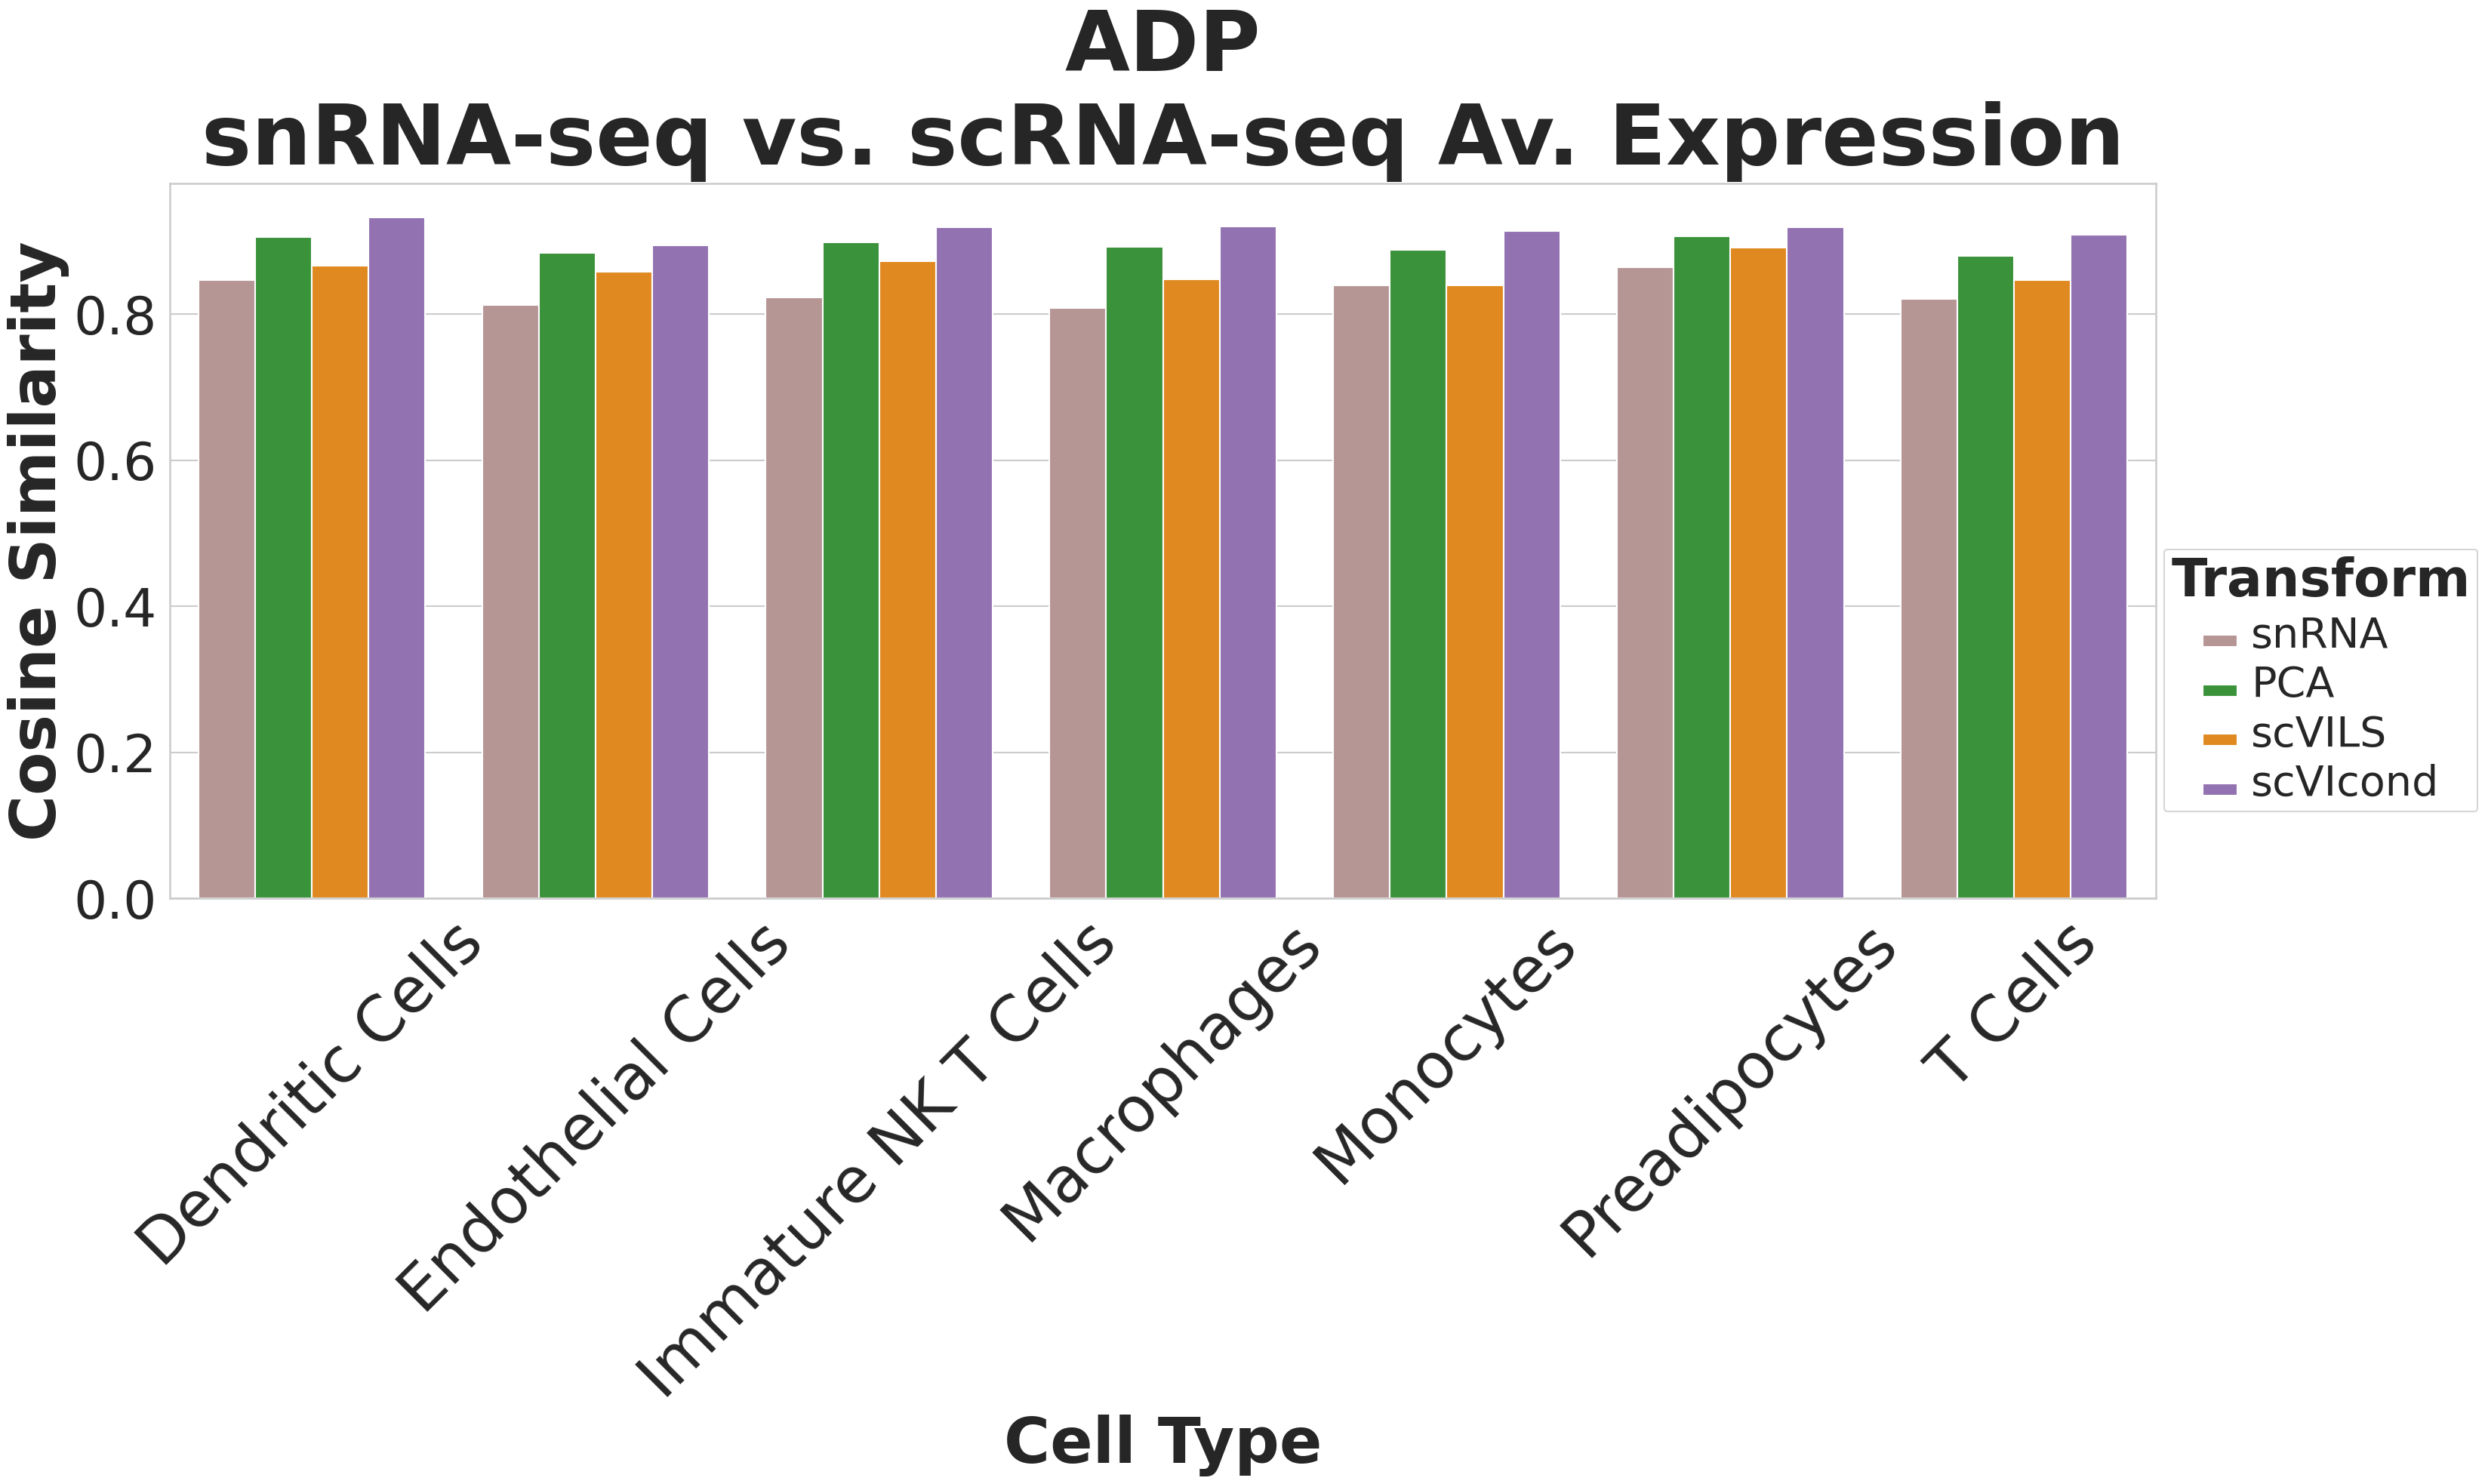

In [9]:
reference_similarity_analysis(
    ds="ADP",
    base_dir=base_dir,
    results=results,
    desired_order=desired_order,
    display_palette=display_palette,
    maps=maps,
)

/scratch/alpine/aivich@xsede.org/PBMC
B Cells
CD4 T Cells
CD8 T Cells
CD14 Monocytes
CD16 Monocytes
Dendritic Cells
Gamma Delta T Cells
Natural Killer Cells
Aggregated Similarity Metrics:
                CellType          Method    Cosine
0            CD4 T Cells          pca_sn  0.937880
1            CD4 T Cells         scvi_sn  0.969168
2            CD4 T Cells          raw_sn  0.898673
3            CD4 T Cells          raw_sc  1.000000
4            CD4 T Cells  scvilsshift_sn  0.925121
5            CD8 T Cells          pca_sn  0.936148
6            CD8 T Cells         scvi_sn  0.961715
7            CD8 T Cells          raw_sn  0.894262
8            CD8 T Cells          raw_sc  1.000000
9            CD8 T Cells  scvilsshift_sn  0.902601
10        CD14 Monocytes          pca_sn  0.934687
11        CD14 Monocytes         scvi_sn  0.956551
12        CD14 Monocytes          raw_sn  0.905043
13        CD14 Monocytes          raw_sc  1.000000
14        CD14 Monocytes  scvilsshift_sn  0.892

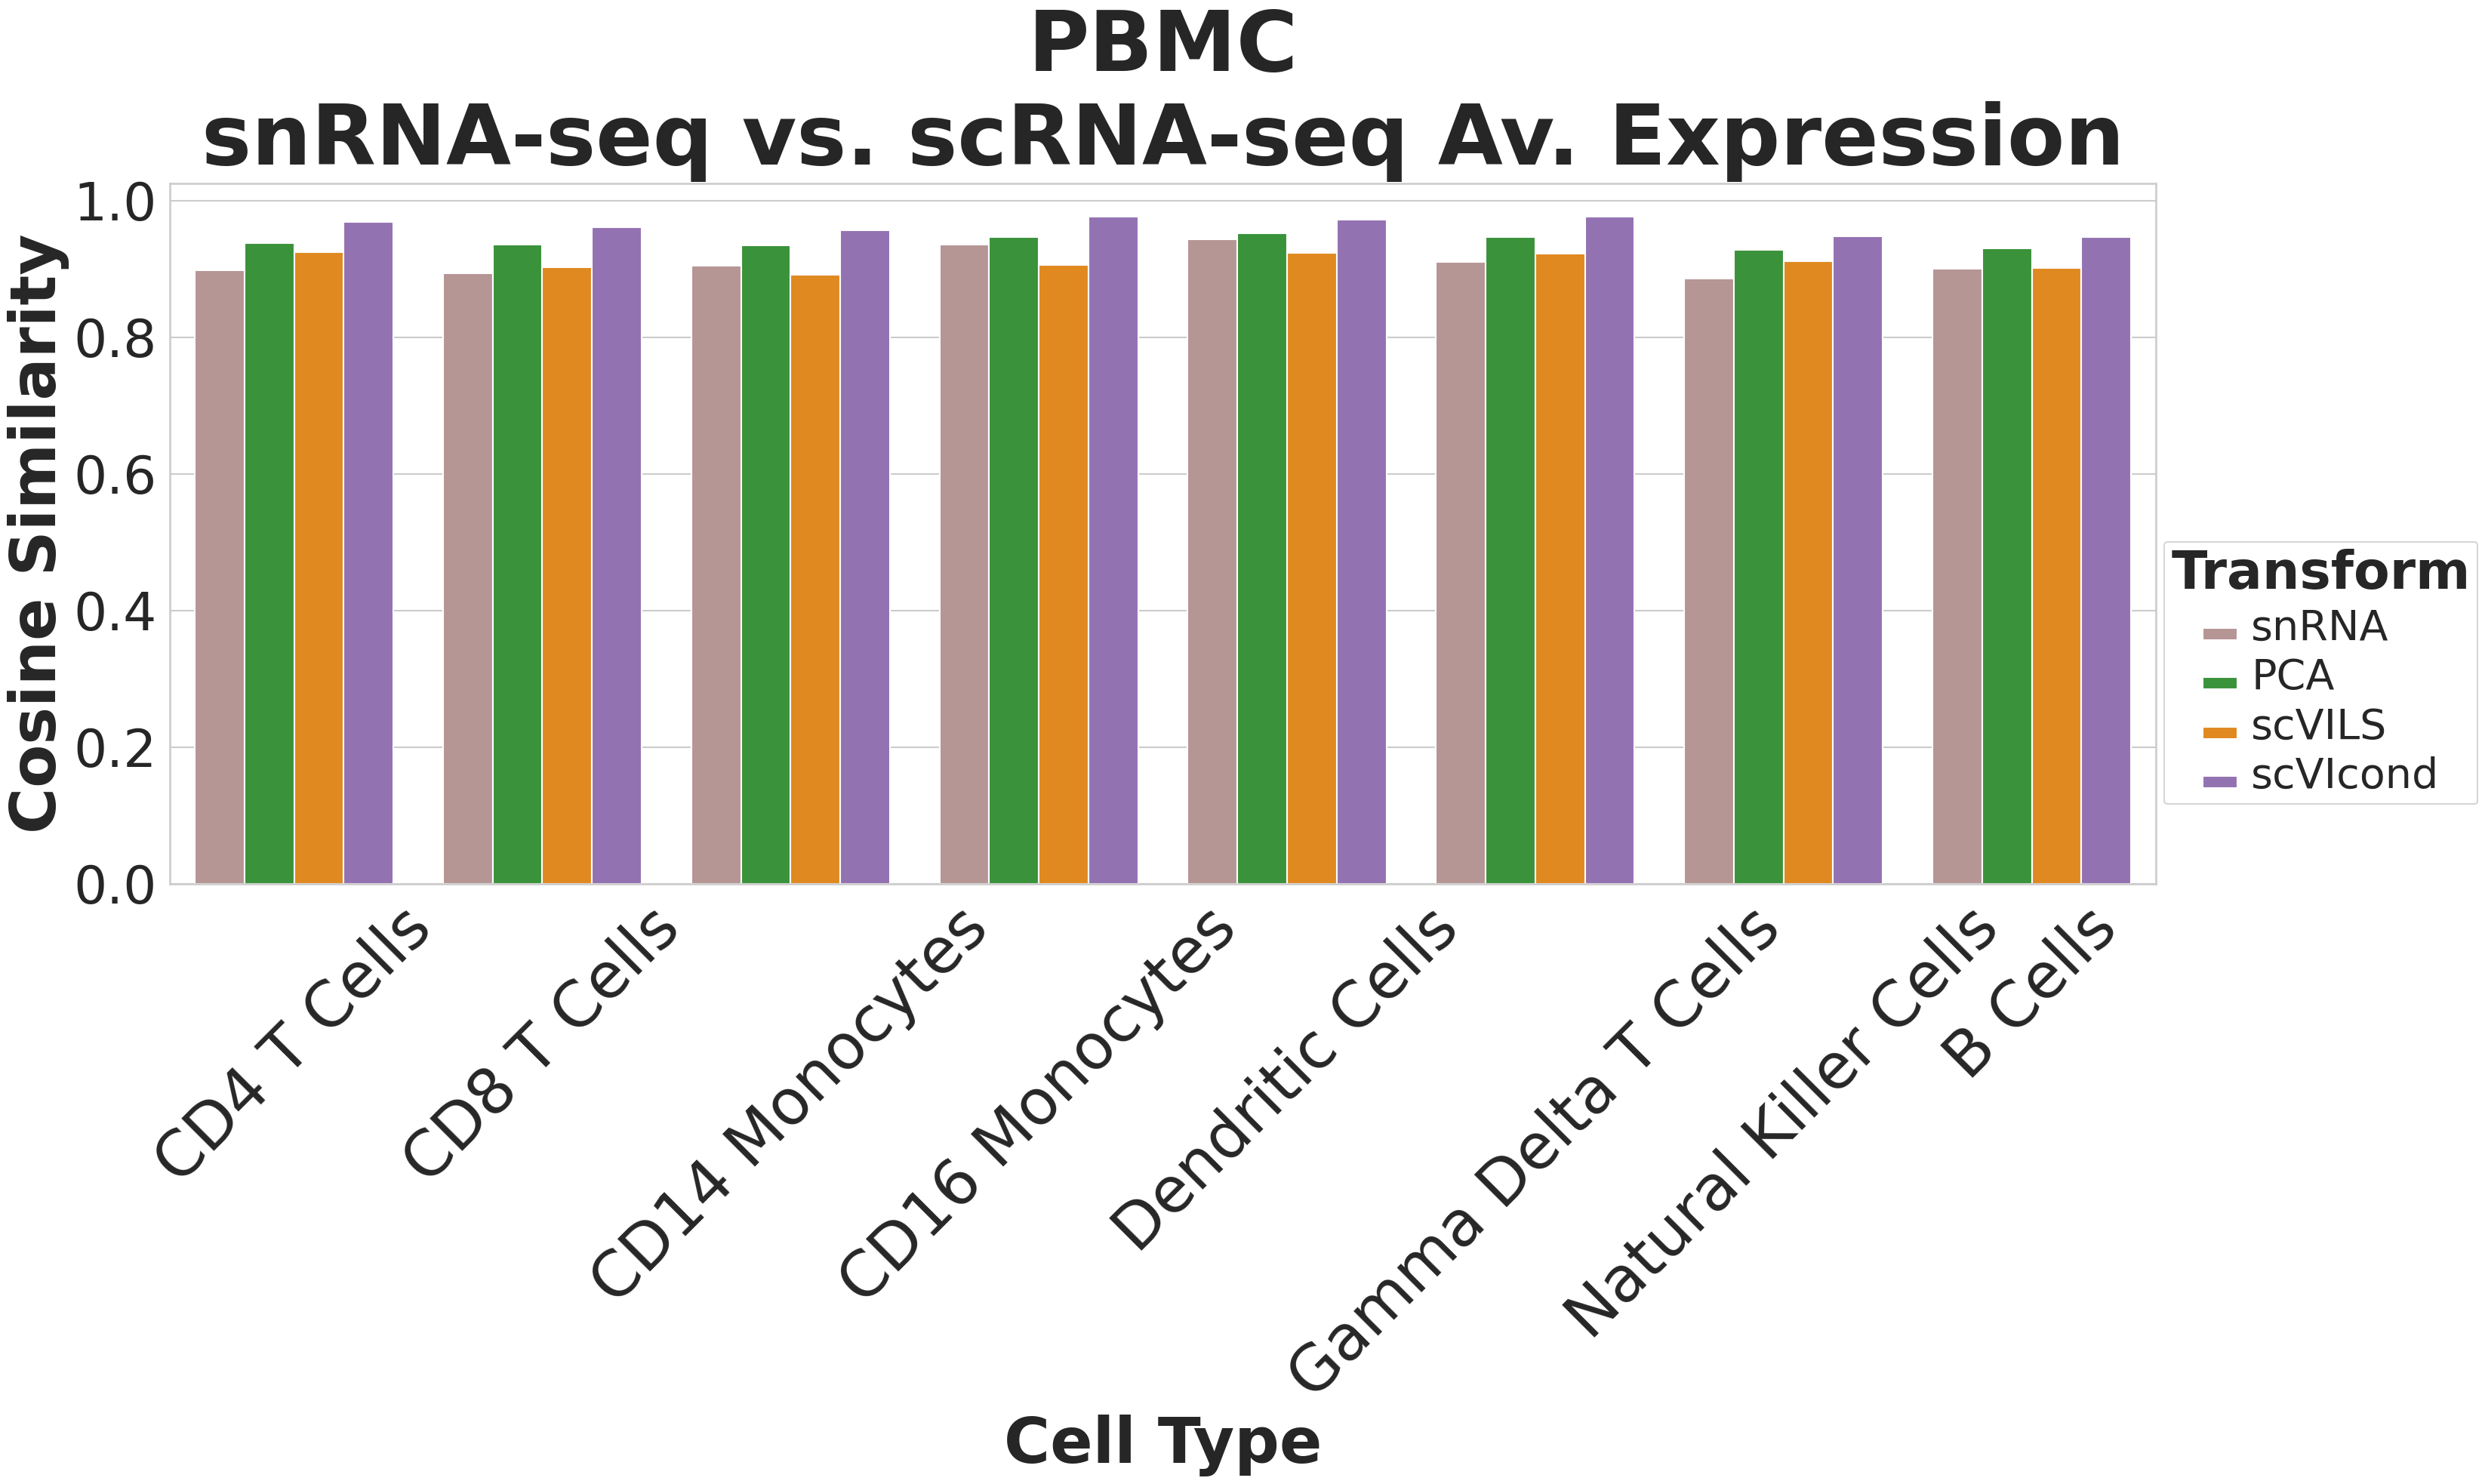

In [10]:
reference_similarity_analysis(
    ds="PBMC",
    base_dir=base_dir,
    results=results,
    desired_order=desired_order,
    display_palette=display_palette,
    maps=maps,
)

/scratch/alpine/aivich@xsede.org/MBC
Endothelial cell
Epithelial cell
Hepatocyte
Macrophage
T cell
Aggregated Similarity Metrics:
            CellType          Method    Cosine
0    Epithelial cell          pca_sn  0.866527
1    Epithelial cell         scvi_sn  0.919191
2    Epithelial cell          raw_sn  0.788216
3    Epithelial cell          raw_sc  1.000000
4    Epithelial cell  scvilsshift_sn  0.787069
5         Hepatocyte          pca_sn  0.859738
6         Hepatocyte         scvi_sn  0.892120
7         Hepatocyte          raw_sn  0.759490
8         Hepatocyte          raw_sc  1.000000
9         Hepatocyte  scvilsshift_sn  0.773688
10        Macrophage          pca_sn  0.871420
11        Macrophage         scvi_sn  0.922219
12        Macrophage          raw_sn  0.750486
13        Macrophage          raw_sc  1.000000
14        Macrophage  scvilsshift_sn  0.758381
15            T cell          pca_sn  0.835640
16            T cell         scvi_sn  0.875060
17            T cell    

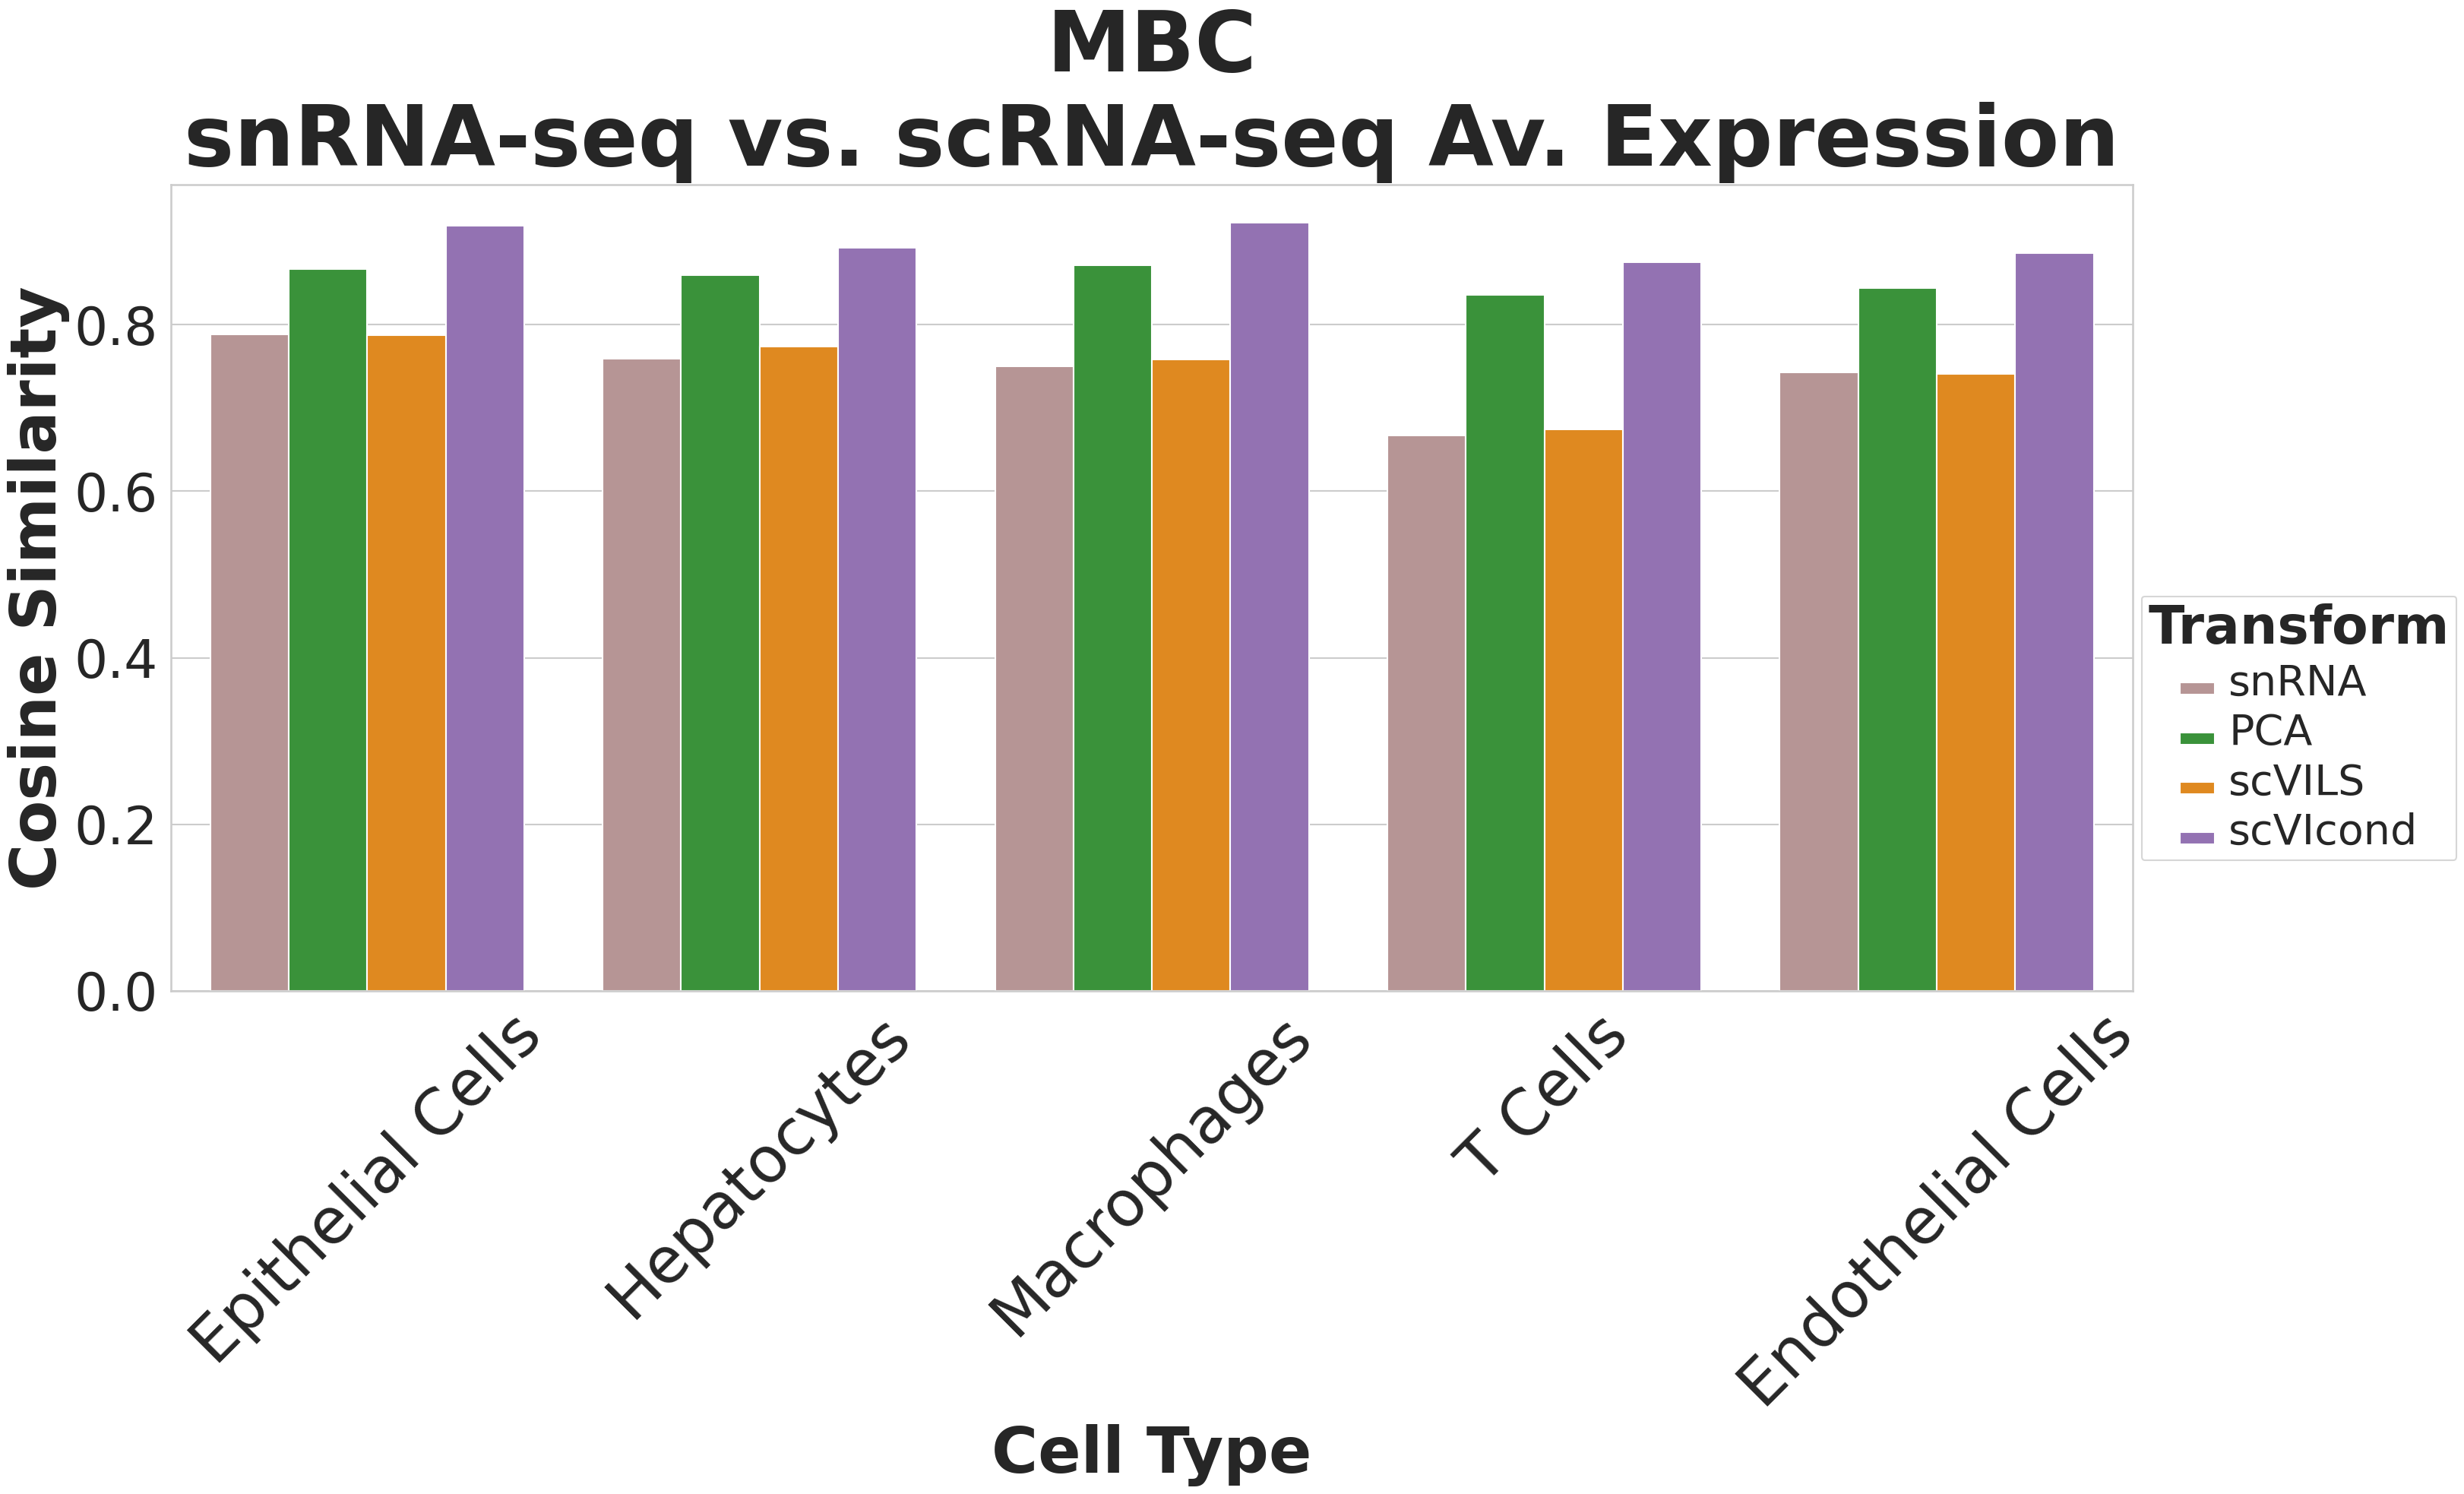

In [11]:
reference_similarity_analysis(
    ds="MBC",
    base_dir=base_dir,
    results=results,
    desired_order=desired_order,
    display_palette=display_palette,
    maps=maps,
)

/scratch/alpine/aivich@xsede.org/MSB
Erythrocyte
Excitatory Neurons
Glial Cells
Inhibitory Neurons
Neuronal Progenitors
Vascular Cells
Aggregated Similarity Metrics:
                CellType          Method    Cosine
0     Excitatory Neurons          pca_sn  0.948958
1     Excitatory Neurons         scvi_sn  0.970580
2     Excitatory Neurons          raw_sn  0.905408
3     Excitatory Neurons          raw_sc  1.000000
4     Excitatory Neurons  scvilsshift_sn  0.890335
5            Glial Cells          pca_sn  0.960459
6            Glial Cells         scvi_sn  0.979451
7            Glial Cells          raw_sn  0.931308
8            Glial Cells          raw_sc  1.000000
9            Glial Cells  scvilsshift_sn  0.889546
10    Inhibitory Neurons          pca_sn  0.933145
11    Inhibitory Neurons         scvi_sn  0.945051
12    Inhibitory Neurons          raw_sn  0.881290
13    Inhibitory Neurons          raw_sc  1.000000
14    Inhibitory Neurons  scvilsshift_sn  0.845239
15  Neuronal Proge

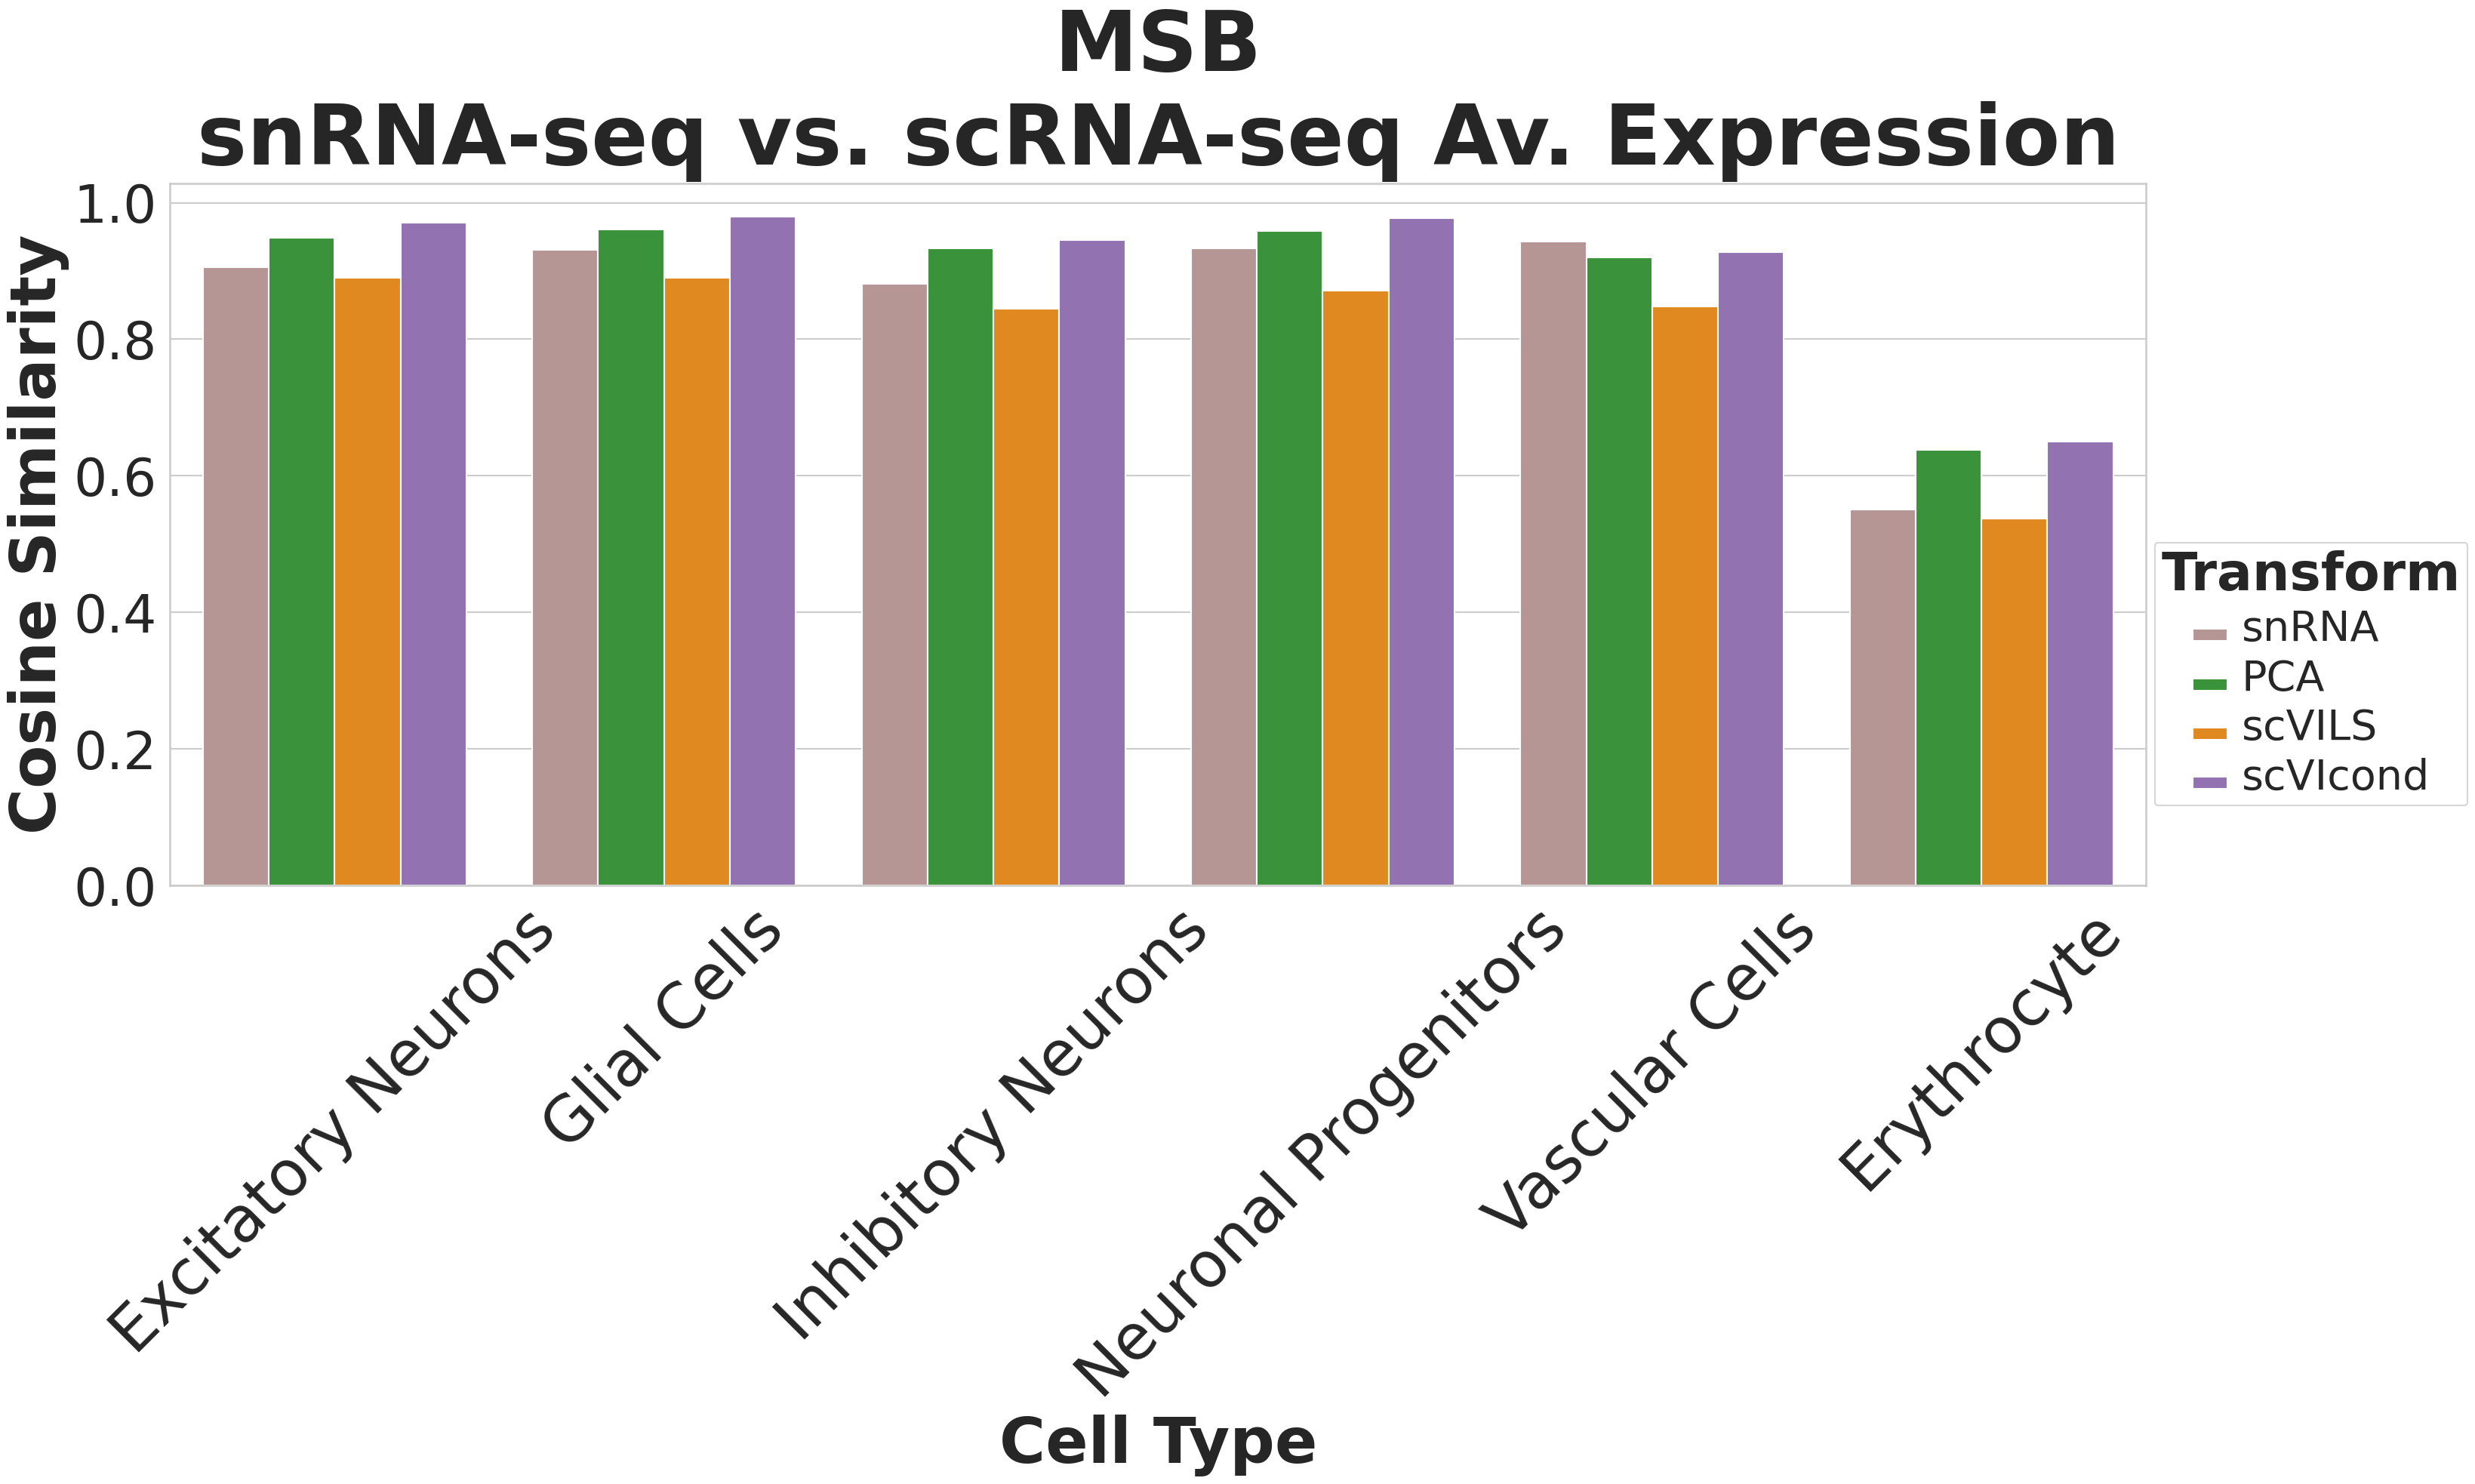

In [12]:
reference_similarity_analysis(
    ds="MSB",
    base_dir=base_dir,
    results=results,
    desired_order=desired_order,
    display_palette=display_palette,
    maps=maps,
)